# Preamble

In [2]:
import numpy as np
import matplotlib.pylab as plt

import pymc as pm
import arviz as az
import aesara.tensor as at
import aesara.tensor.extra_ops as ate

import astropy.cosmology as cosmo
import astropy.units as u
import h5py

# Data Generation

Redshift Distribution approximately follows M-D 2014.
$$
z \sim 10\beta_z(3, 9)
$$

In [3]:
Nobs = 1000

Text(0, 0.5, 'Number')

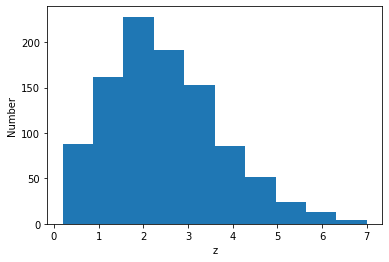

In [4]:
z = np.random.beta(3, 9, Nobs)*10
plt.hist(z)
plt.xlabel('z')
plt.ylabel('Number')

Source frame chirp mass follows galactic neutron star population,

$$
M_c \sim N(1.17 M_{\odot}, 0.1M_{\odot})
$$

Text(0, 0.5, 'Number')

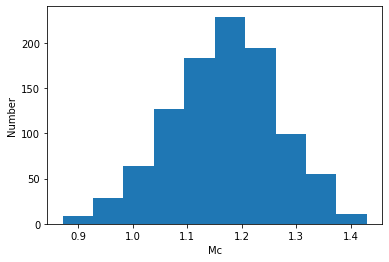

In [5]:
Mc = np.random.normal(1.17, 0.1, Nobs) # in solar mass unit
plt.hist(Mc)
plt.xlabel('Mc')
plt.ylabel('Number')

Detector frame chirp mass,
$$
Mcz = Mc(1+z)
$$

Text(0, 0.5, 'Number')

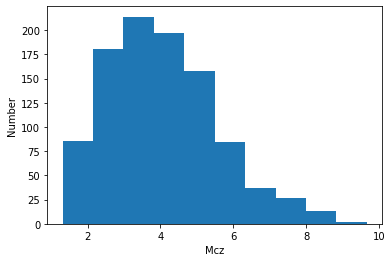

In [6]:
Mcz = Mc*(1+z)
plt.hist(Mcz)
plt.xlabel('Mcz')
plt.ylabel('Number')

Cosmology is assumed to be Planck18. $\sigma_{DL}/DL$ is inversely proportional to snr, reaching 30% of snr at z=10. Also place a lower cut $\sigma_{DL}/DL$ is 0.1 to avoid unphysical scenario of $\sigma_{DL} \rightarrow 0$ at low $z$.

$$
\frac{\sigma_{DL}}{DL} = 0.1 + 0.3 \frac{DL}{DL(z=10)}
$$

Text(0, 0.5, 'Number')

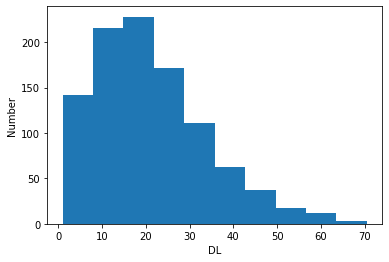

In [7]:
cp = cosmo.Planck18
DL = cp.luminosity_distance(z).to(u.Gpc).value
plt.hist(DL)
plt.xlabel('DL')
plt.ylabel('Number')

In [8]:
DL10 = cp.luminosity_distance(10).to(u.Gpc).value
sigma_DL = DL*(0.1+0.3*(DL/DL10))

$$
zo = z, do = DL+\sigma_{DL}*randn(Nobs)
$$

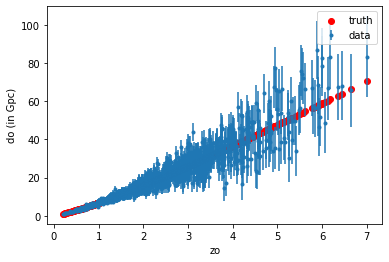

In [9]:
zo = z
do = DL+sigma_DL*np.random.randn(Nobs) # in Gpc
plt.errorbar(zo, do, yerr=sigma_DL, fmt='.', label='data')
plt.scatter(zo, cp.luminosity_distance(zo).to(u.Gpc).value, color='red', label='truth')
plt.xlabel('zo')
plt.ylabel('do (in Gpc)')
plt.legend()

# Pop Cosmo Estimation

Let's plot the residue.

Text(0, 0.5, 'residue')

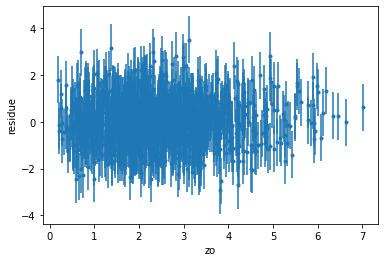

In [10]:
plt.errorbar(zo, (do-cp.luminosity_distance(zo).to(u.Gpc).value)/sigma_DL, yerr=np.ones(Nobs), fmt='.')
plt.xlabel('zo')
plt.ylabel('residue')

# Toy Model I

Here $\vec{\Omega}_P = \{\mu_P, \sigma_P \}$, and $\vec{\Omega}_C = \{H_0, \Omega_M, w \}$.

Under simplified asuumptions:
1. no covariance between $M_{cz}^{obs}$ and $D_L^{obs}$,
2. $\sigma_{M_{cz}^{obs}} = 0$

$M_{cz}$ integral becomes analytic.

Posterior of $\{\mu_P, \sigma_P, H_0, \Omega_M, w \}$ is,

$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto P(\mu_P).P(\sigma_P).P(H_0).P(\Omega_M).P(w).\prod_i \int_{D_L} N_{D_L}(D_L^{obs, i}, \sigma_{D_L}^{obs, i}).P(D_L).\Big(\frac{1}{1+z(D_L, H_0, \Omega_M, w)}\Big ).N_{\Big( \frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)}\Big )}(\mu_P, \sigma_P).dD_L
$$

Here we will investigate whether Posterior is more informative than Prior or not.  

Pymc does not have interpolation module, so it is written.

In [11]:
def at_interp(x, xs, ys):
    x = at.as_tensor(x)
    xs = at.as_tensor(xs)
    ys = at.as_tensor(ys)

    ind = ate.searchsorted(xs, x)
    r = (x - xs[ind-1])/(xs[ind]-xs[ind-1])
    return r*ys[ind] + (1-r)*ys[ind-1]

Routine for Luminosity Distance

In [12]:
def Ez(z, Om, w, wDM):
    opz = 1 + z
    return at.sqrt(Om*opz**(3*(1+wDM)) + (1-Om)*opz**(3*(1+w)))

def dCs(zs, Om, w, wDM):
    dz = zs[1:] - zs[:-1]
    fz = 1/Ez(zs, Om, w, wDM)
    I = 0.5*dz*(fz[:-1] + fz[1:])
    return at.concatenate([at.as_tensor([0.0]), at.cumsum(I)])

def dLs(zs, dCs):
    return dCs*(1+zs)

Cosmological Parameter Estimation by Pymc

A note on the maths:
$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto P(\mu_P).P(\sigma_P).P(H_0).P(\Omega_M).P(w).\prod_i \int_{D_L} N_{D_L}(D_L^{obs, i}, \sigma_{D_L}^{obs, i}).P(D_L).\Big(\frac{1}{1+z(D_L, H_0, \Omega_M, w)}\Big ).N_{\Big( \frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)}\Big )}(\mu_P, \sigma_P).dD_L
$$

as $P(D_L)=P(z).\frac{dz}{dD_L}$,

$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto P(\mu_P).P(\sigma_P).P(H_0).P(\Omega_M).P(w).\prod_i \int_{z} N_{D_L(z, H_0, \Omega_M, w)}(D_L^{obs, i}, \sigma_{D_L}^{obs, i}).P(z).\Big(\frac{1}{1+z}\Big ).N_{\Big( \frac{M_{cz}^{obs, i}}{1+z}\Big )}(\mu_P, \sigma_P).dz
$$

or,

$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto \prod_i \left\langle \int_{z} N_{D_L(z, H_0, \Omega_M, w)}(D_L^{obs, i}, \sigma_{D_L}^{obs, i}).P(z).\Big(\frac{1}{1+z}\Big ).N_{\Big( \frac{M_{cz}^{obs, i}}{1+z}\Big )}(\mu_P, \sigma_P).dz \right\rangle _{\mu_P, ~\sigma_P, ~H_0, ~\Omega_M, ~w ~samples}
$$

or,

$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto \prod_i \left\langle N_{D_L(z, H_0, \Omega_M, w)}(D_L^{obs, i}, \sigma_{D_L}^{obs, i}).\Big(\frac{1}{1+z}\Big ).N_{\Big( \frac{M_{cz}^{obs, i}}{1+z}\Big )}(\mu_P, \sigma_P) \right\rangle _{\mu_P, ~\sigma_P, ~H_0, ~\Omega_M, ~w, ~z ~samples}
$$

In [13]:
wDM = 0

In [15]:
def make_model(Mcz, do, sigma_DL, zmax=100, Nz=1024):
    
    Mcz = np.atleast_1d(Mcz)
    Nobs = Mcz.shape[0]

    zinterp = np.expm1(np.linspace(np.log(1), np.log1p(zmax), Nz))

    with pm.Model() as model:        
        mu_P = pm.Uniform('mu_P', 0.7, 1.7) #in solar mass unit
        sigma_P = pm.Uniform('sigma_P', 0.05, 0.15)

        h = pm.Uniform('h', 0.2, 1.2)
        Om = pm.Uniform('Om', 0.1, 0.5)
        w = pm.Uniform('w', -1.5, -0.5)
        
        dH = pm.Deterministic('dH', 2.99792 / h) # Gpc
        
        z_unit = pm.Beta('z_unit', 3, 9, shape=Nobs)
        z = pm.Deterministic('z', z_unit*10)
        
        Mc = pm.Deterministic('Mc', Mcz/(1 + z))
        pm.Potential('mcprior', at.sum(pm.logp(pm.Normal.dist(mu_P, sigma_P), Mc))) #why are we always taking logs?
        pm.Potential('mcjac', at.sum(-at.log1p(z))) # Comes from integrating over delta-function likelihood for mc

        dCinterp = dH*dCs(zinterp, Om, w, wDM)
        dLinterp = dLs(zinterp, dCinterp)

        dL = pm.Deterministic('dL', at_interp(z, zinterp, dLinterp))

        pm.Normal('dL_likelihood', mu=dL, sigma=sigma_DL, observed=do)
    return model

In [19]:
tune = 1000
target_accept = 0.99
with make_model(Mcz, do, sigma_DL) as model:
    trace = pm.sample(tune=tune, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, sigma_P, h, Om, w, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 582 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


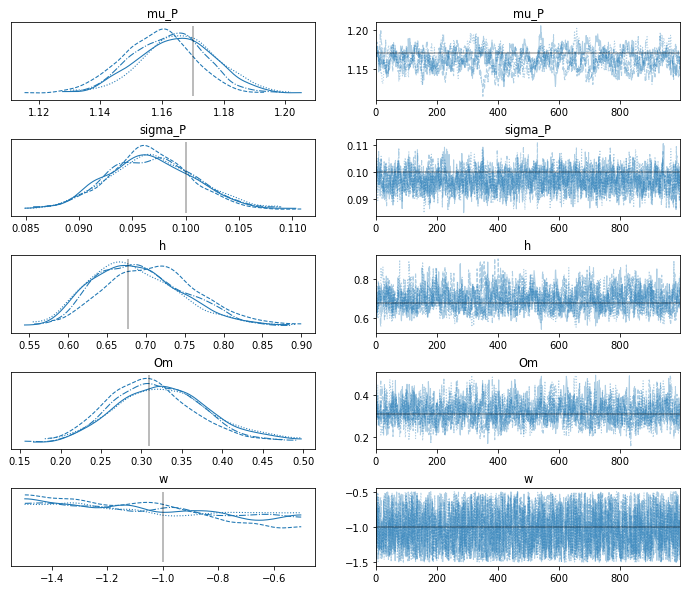

In [20]:
with model:
    axes = az.plot_trace(trace, compact=True, var_names=['mu_P', 'sigma_P', 'h', 'Om', 'w'],
                        lines=[('mu_P', {}, 1.17),
                        ('sigma_P', {}, 0.1),
                        ('h', {}, cp.H0/100),
                        ('Om', {}, cp.Om0),
                        ('w', {}, -1)])
    fig = axes.ravel()[0].figure.subplots_adjust(hspace=0.5)

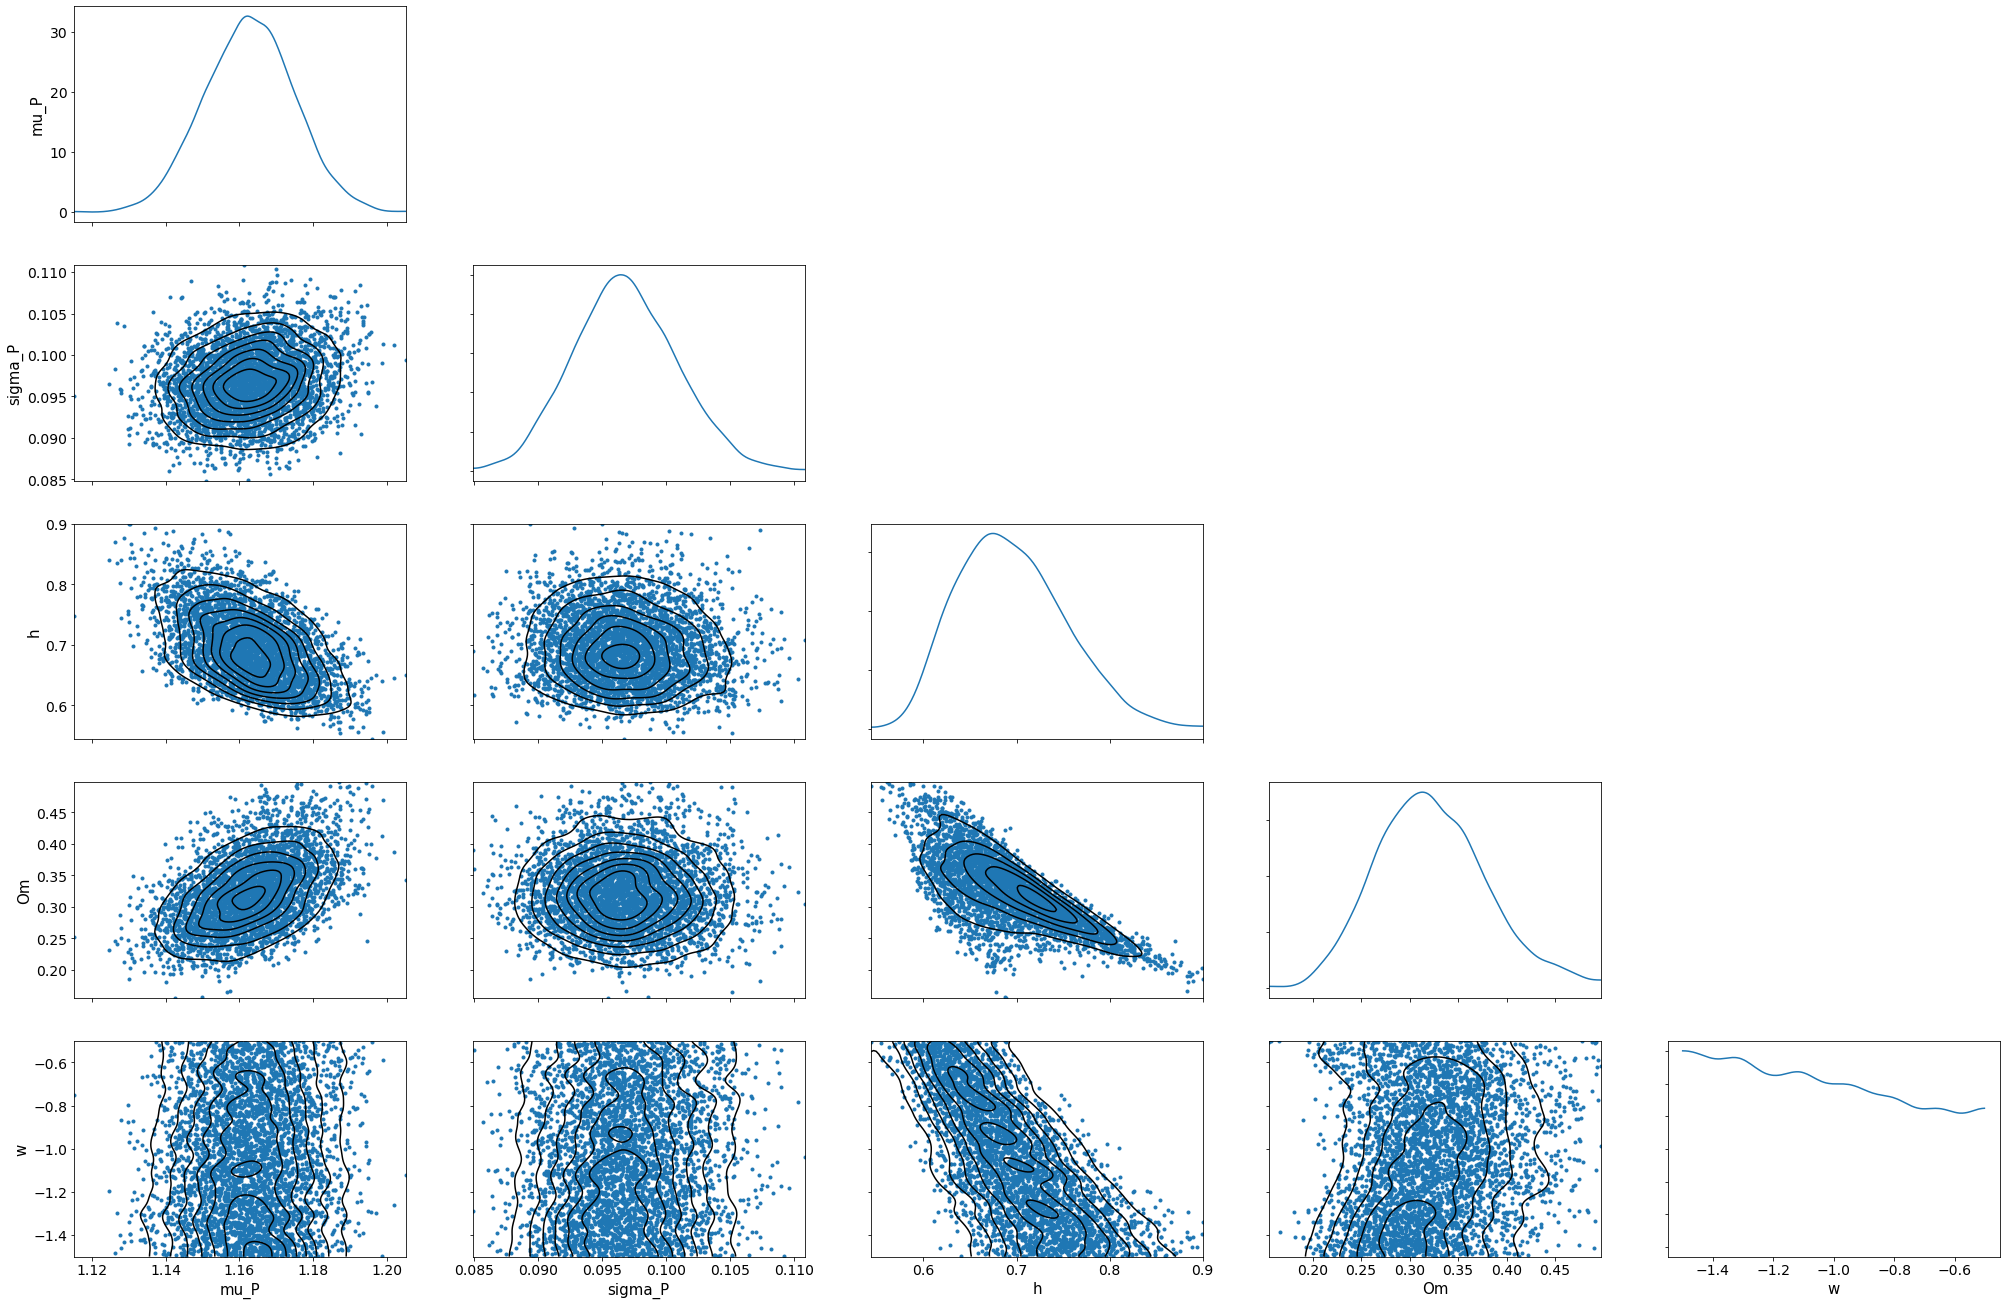

In [21]:
axes = az.plot_pair(trace, var_names=['mu_P', 'sigma_P', 'h', 'Om', 'w'], marginals=True, kind=['scatter', 'kde'], divergences=True)
fig = axes.ravel()[0].figure

In [22]:
with model:
    display(az.summary(trace, var_names=['mu_P', 'sigma_P', 'h', 'Om', 'w']))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_P,1.163,0.012,1.139,1.185,0.001,0.001,80.0,359.0,1.05
sigma_P,0.097,0.004,0.089,0.104,0.000,0.000,1350.0,2572.0,1.00
h,0.695,0.058,0.597,0.805,0.003,0.002,371.0,1156.0,1.02
Om,0.322,0.057,0.212,0.425,0.002,0.002,545.0,1354.0,1.01
w,-1.035,0.287,-1.499,-0.572,0.005,0.004,2667.0,2403.0,1.00
